# tutti gli account 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gower
import umap.umap_ as umap
from pyclustering.cluster.kmedoids import kmedoids
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from pyclustering.utils import distance_metric, type_metric
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

c:\Users\Antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)

In [3]:
accounts = pd.read_excel('./tutti_account_thesis.xlsx')

In [4]:
accounts = accounts.iloc[:,3:]

In [5]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti
0,Ascom UMS Srl,Non interessato,Partnership,Scouting,Industria Meccanica e Automazione,8500000.0,75.0
1,Ubiquicom S.r.l.,Ingaggiato,Partnership,Newsletter,Informatica e Software,3700000.0,45.0
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria Tessile e Abbigliamento,65000000.0,600.0
3,RAL FILATI SRL,Cliente,Formazione,Partner,Industria Tessile e Abbigliamento,14134435.0,38.0
4,ZERBI S.R.L.,Cliente,Formazione,Partner,"Servizi Legali, Notarili e di Consulenza",7313875.0,14.0
...,...,...,...,...,...,...,...
3196,Veronasped S.r.l.,Ingaggiato,NaN,Partner,Servizi per le imprese,1200000.0,4.0
3197,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi al CC,Industria Alimentare e Bevande,350000000.0,200.0
3198,40factory,Partner,Formazione; Progetti,Nuova richiesta,Informatica e Software,1300000.0,16.0
3199,Termoresine,NaN,NaN,NaN,NaN,NaN,NaN


- rimuovere valori mancanti
- creare variabili 'ricavi_per_dipendente' e 'dimensione aziendale'
- rimuovere variabili 'ricavi annuali' e 'numero di dipendenti'
- trasformazione logaritmica
- standardizzazione
- rimozione outlier
- applicare umap con distanza di gower
- applicare pam con distanza di gower

## rimozione valori mancanti

In [6]:
accounts.isna().sum()

Nome account              0
Status                   53
Tipo di interesse       290
Sorgente                 27
Settore                 112
Ricavi annuali          606
Numero di dipendenti    709
dtype: int64

In [7]:
accounts.drop_duplicates(inplace=True)

In [8]:
accounts.dropna(inplace=True)

In [9]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti
0,Ascom UMS Srl,Non interessato,Partnership,Scouting,Industria Meccanica e Automazione,8500000.0,75.0
1,Ubiquicom S.r.l.,Ingaggiato,Partnership,Newsletter,Informatica e Software,3700000.0,45.0
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria Tessile e Abbigliamento,65000000.0,600.0
3,RAL FILATI SRL,Cliente,Formazione,Partner,Industria Tessile e Abbigliamento,14134435.0,38.0
4,ZERBI S.R.L.,Cliente,Formazione,Partner,"Servizi Legali, Notarili e di Consulenza",7313875.0,14.0
...,...,...,...,...,...,...,...
3194,CAODURO S.P.A.,Ingaggiato,Progetti,Partner,Industria Edilizia e Costruzioni,15000000.0,57.0
3195,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Partner,Industria Meccanica e Automazione,30000000.0,170.0
3197,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi al CC,Industria Alimentare e Bevande,350000000.0,200.0
3198,40factory,Partner,Formazione; Progetti,Nuova richiesta,Informatica e Software,1300000.0,16.0


In [10]:
accounts.isna().sum()

Nome account            0
Status                  0
Tipo di interesse       0
Sorgente                0
Settore                 0
Ricavi annuali          0
Numero di dipendenti    0
dtype: int64

In [11]:
for i in accounts[['Status','Tipo di interesse','Sorgente','Settore']]:
    accounts[i] = accounts[i].astype(str).str.replace(r'[ ;]','_',regex=True)

In [12]:
accounts.reset_index(inplace=True,drop=True)

In [13]:
accounts['Ricavi annuali'] = accounts['Ricavi annuali'].apply(pd.to_numeric, errors='coerce')

In [14]:
accounts['Numero di dipendenti'] = accounts['Numero di dipendenti'].apply(pd.to_numeric, errors='coerce')

In [15]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti
0,Ascom UMS Srl,Non_interessato,Partnership,Scouting,Industria_Meccanica_e_Automazione,8500000.0,75.0
1,Ubiquicom S.r.l.,Ingaggiato,Partnership,Newsletter,Informatica_e_Software,3700000.0,45.0
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria_Tessile_e_Abbigliamento,65000000.0,600.0
3,RAL FILATI SRL,Cliente,Formazione,Partner,Industria_Tessile_e_Abbigliamento,14134435.0,38.0
4,ZERBI S.R.L.,Cliente,Formazione,Partner,"Servizi_Legali,_Notarili_e_di_Consulenza",7313875.0,14.0
...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Partner,Industria_Edilizia_e_Costruzioni,15000000.0,57.0
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Partner,Industria_Meccanica_e_Automazione,30000000.0,170.0
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi_al_CC,Industria_Alimentare_e_Bevande,350000000.0,200.0
2279,40factory,Partner,Formazione__Progetti,Nuova_richiesta,Informatica_e_Software,1300000.0,16.0


## creazioni variablili

In [16]:
accounts['Ricavi_per_dipendente'] = accounts['Ricavi annuali'] / accounts['Numero di dipendenti']

In [17]:
def dimensione_azienda(row):
    if row['Numero di dipendenti'] < 10 and row['Ricavi annuali'] < 2_000_000:
        return 1
    elif 10 <= row['Numero di dipendenti'] <= 49 and row['Ricavi annuali'] < 10_000_000:
        return 2
    elif 50 <= row['Numero di dipendenti'] <= 249 and row['Ricavi annuali'] < 50_000_000:
        return 3
    else:
        return 4

In [18]:
accounts['Dimensione_azienda'] = accounts.apply(dimensione_azienda, axis=1)

In [19]:
accounts['Ricavi_per_dipendente'] = accounts['Ricavi_per_dipendente'].replace([float('inf'), -float('inf')], np.nan)

In [20]:
accounts.dropna(inplace=True)

In [21]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti,Ricavi_per_dipendente,Dimensione_azienda
0,Ascom UMS Srl,Non_interessato,Partnership,Scouting,Industria_Meccanica_e_Automazione,8500000.0,75.0,1.133333e+05,3
1,Ubiquicom S.r.l.,Ingaggiato,Partnership,Newsletter,Informatica_e_Software,3700000.0,45.0,8.222222e+04,2
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria_Tessile_e_Abbigliamento,65000000.0,600.0,1.083333e+05,4
3,RAL FILATI SRL,Cliente,Formazione,Partner,Industria_Tessile_e_Abbigliamento,14134435.0,38.0,3.719588e+05,4
4,ZERBI S.R.L.,Cliente,Formazione,Partner,"Servizi_Legali,_Notarili_e_di_Consulenza",7313875.0,14.0,5.224196e+05,2
...,...,...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Partner,Industria_Edilizia_e_Costruzioni,15000000.0,57.0,2.631579e+05,3
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Partner,Industria_Meccanica_e_Automazione,30000000.0,170.0,1.764706e+05,3
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi_al_CC,Industria_Alimentare_e_Bevande,350000000.0,200.0,1.750000e+06,4
2279,40factory,Partner,Formazione__Progetti,Nuova_richiesta,Informatica_e_Software,1300000.0,16.0,8.125000e+04,2


## trasformazione logaritmica e standardizzazione

In [22]:
accounts['Ricavi annuali'] = np.log1p(accounts['Ricavi annuali'])

In [23]:
accounts['Numero di dipendenti'] = np.log1p(accounts['Numero di dipendenti'])

In [24]:
accounts['Ricavi_per_dipendente'] = np.log1p(accounts['Ricavi_per_dipendente'])

In [25]:
scaler = StandardScaler()

In [26]:
accounts['Ricavi_per_dipendente'] = scaler.fit_transform(accounts[['Ricavi_per_dipendente']])

In [27]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti,Ricavi_per_dipendente,Dimensione_azienda
0,Ascom UMS Srl,Non_interessato,Partnership,Scouting,Industria_Meccanica_e_Automazione,15.955577,4.330733,-0.240607,3
1,Ubiquicom S.r.l.,Ingaggiato,Partnership,Newsletter,Informatica_e_Software,15.123844,3.828641,-0.418866,2
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria_Tessile_e_Abbigliamento,17.989898,6.398595,-0.265670,4
3,RAL FILATI SRL,Cliente,Formazione,Partner,Industria_Tessile_e_Abbigliamento,16.464125,3.663562,0.419562,4
4,ZERBI S.R.L.,Cliente,Formazione,Partner,"Servizi_Legali,_Notarili_e_di_Consulenza",15.805284,2.708050,0.608254,2
...,...,...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Partner,Industria_Edilizia_e_Costruzioni,16.523561,4.060443,0.227347,3
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Partner,Industria_Meccanica_e_Automazione,17.216708,5.141664,0.005374,3
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi_al_CC,Industria_Alimentare_e_Bevande,19.673444,5.303305,1.279785,4
2279,40factory,Partner,Formazione__Progetti,Nuova_richiesta,Informatica_e_Software,14.077876,2.833213,-0.425473,2


## eda and feature standardization

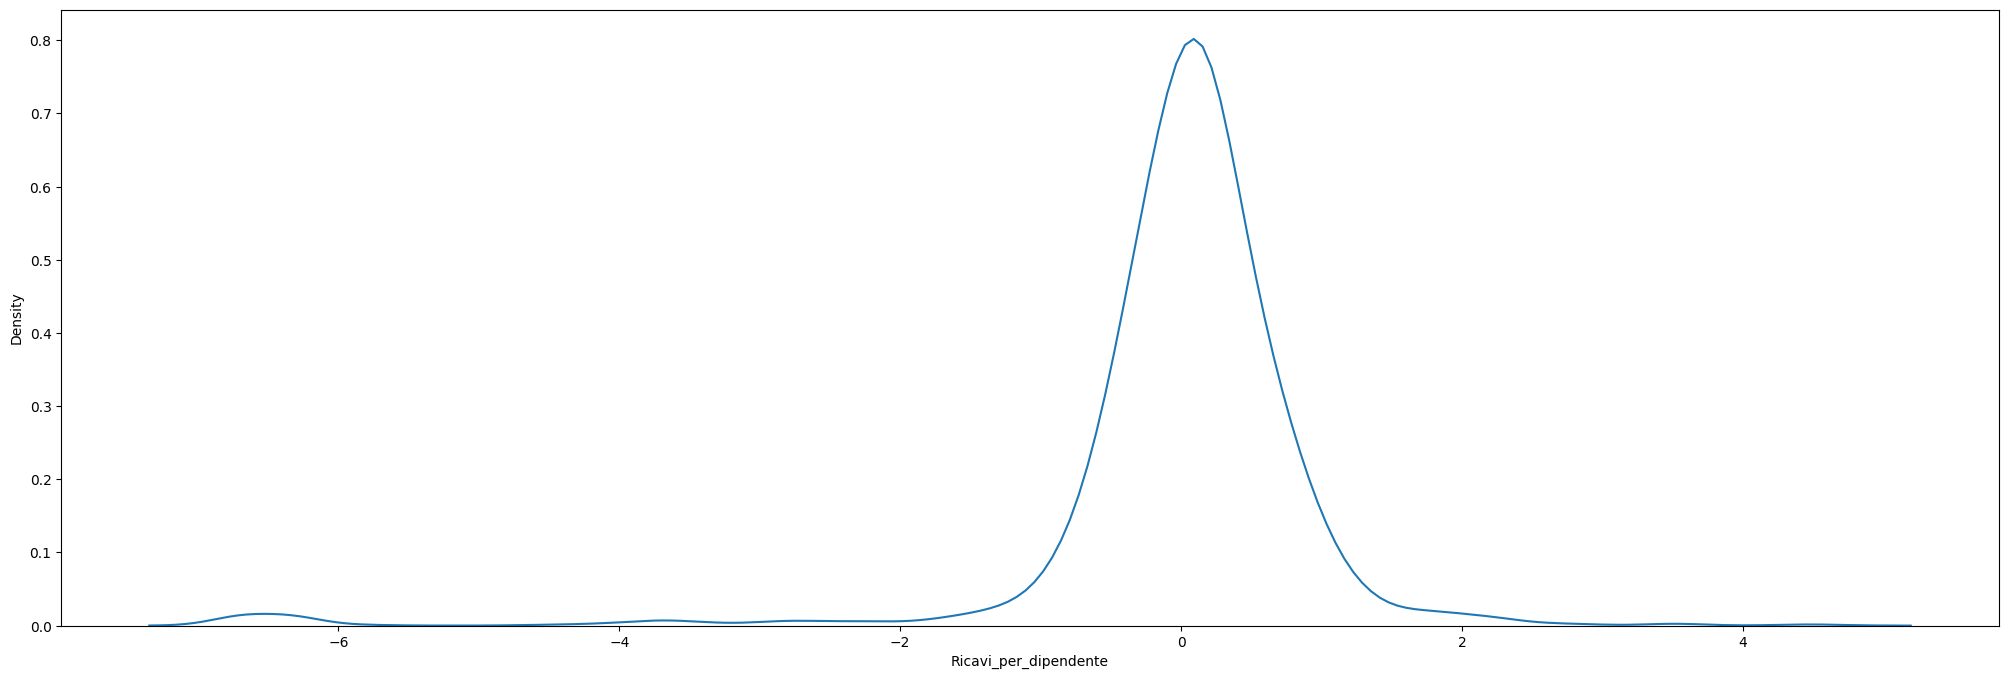

In [28]:
plt.figure(figsize=(25,8))
sns.kdeplot(accounts['Ricavi_per_dipendente'])
plt.show()

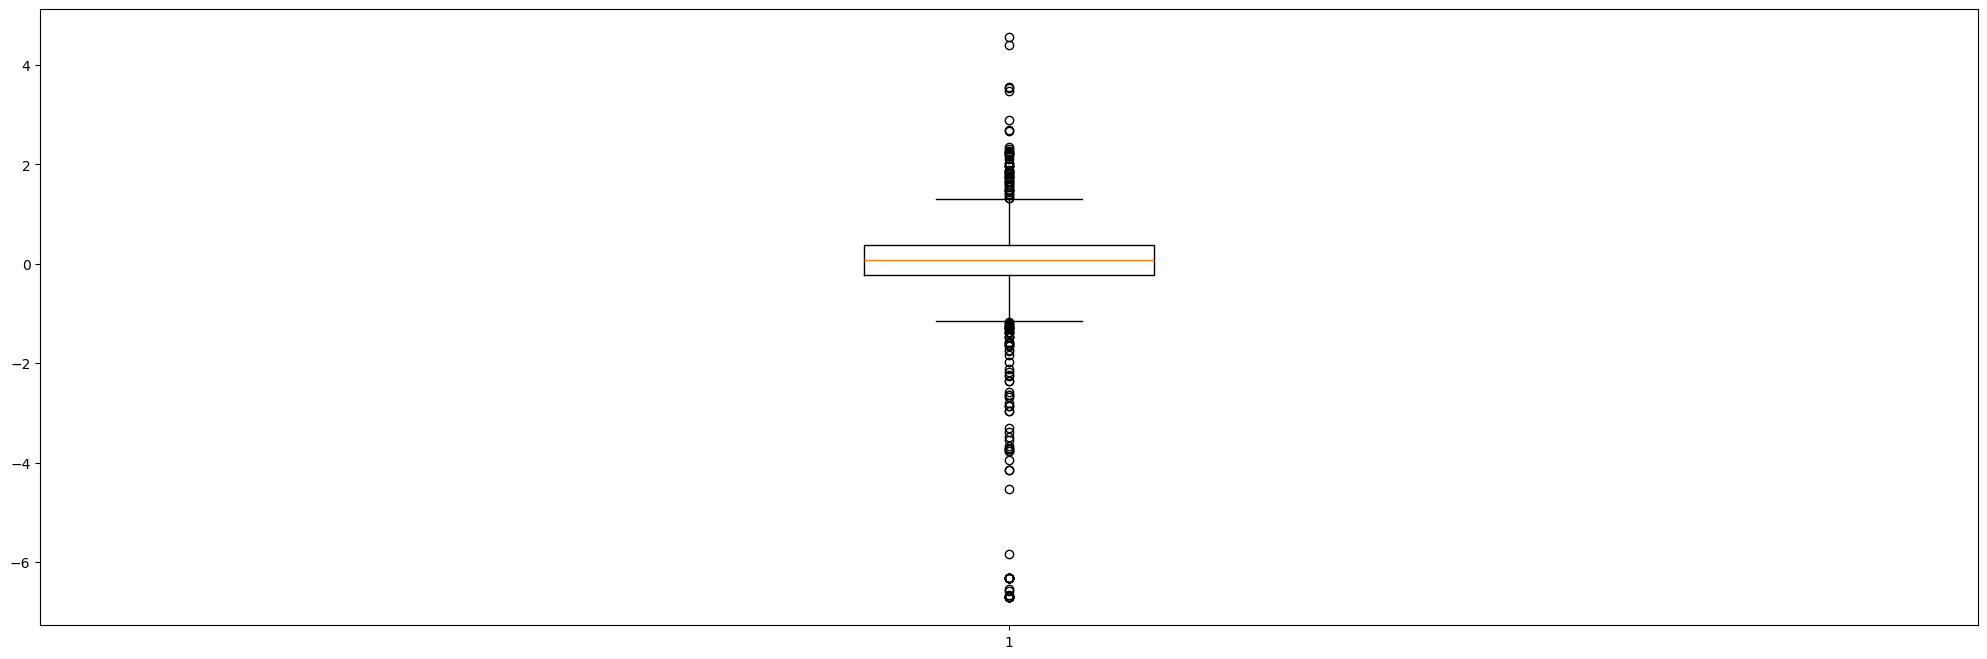

In [29]:
col = pd.to_numeric(accounts['Ricavi_per_dipendente'], errors='coerce')
plt.figure(figsize=(25,8))
plt.boxplot(col.dropna())
plt.show()

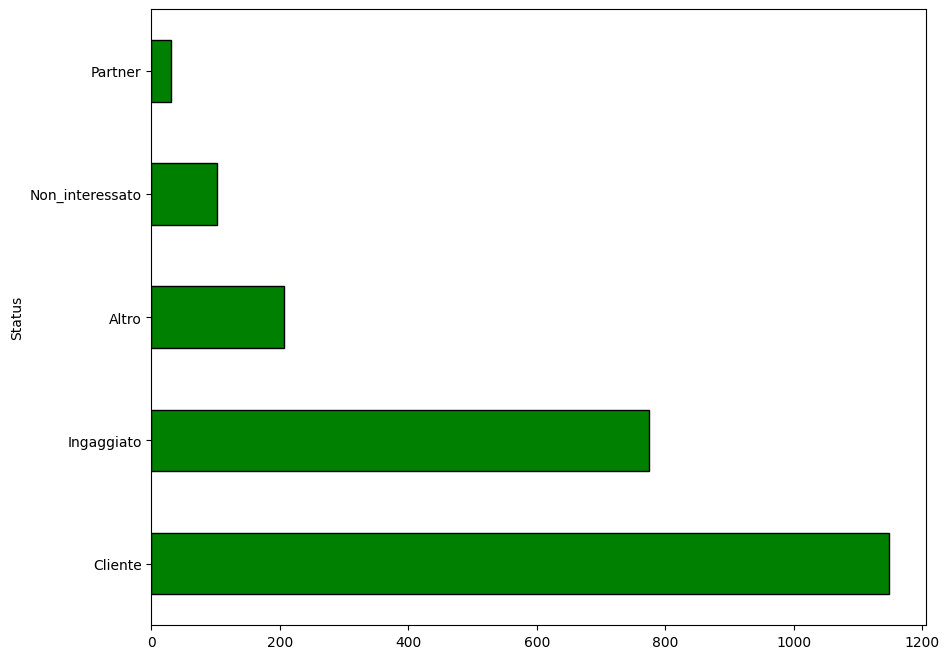

In [30]:
plt.figure(figsize=(10,8))
accounts["Status"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

In [31]:
accounts['Status'] = accounts['Status'].replace({'Non_interessato':'Altro', 'Partner':'Cliente'})

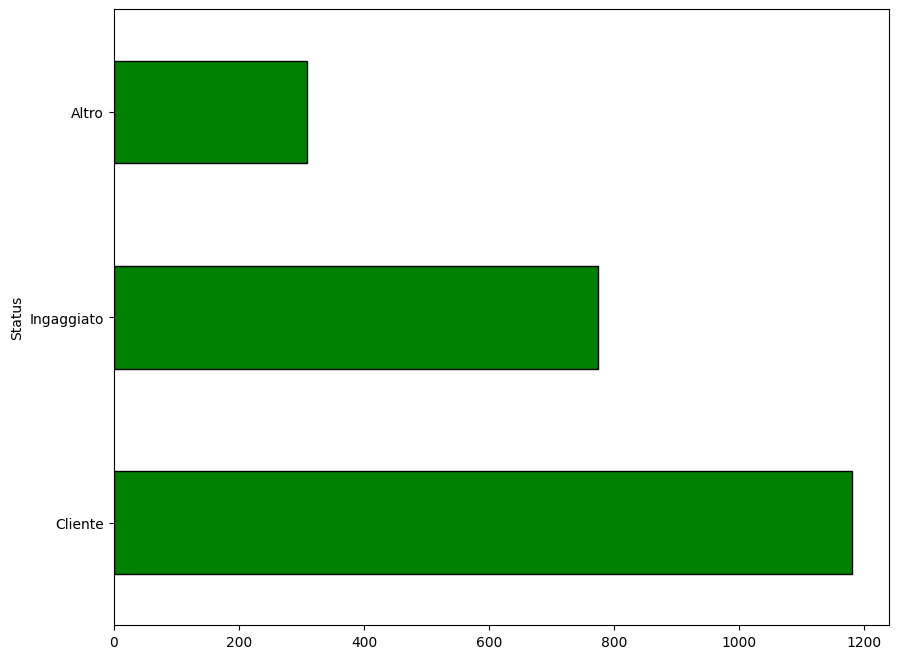

In [32]:
plt.figure(figsize=(10,8))
accounts["Status"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

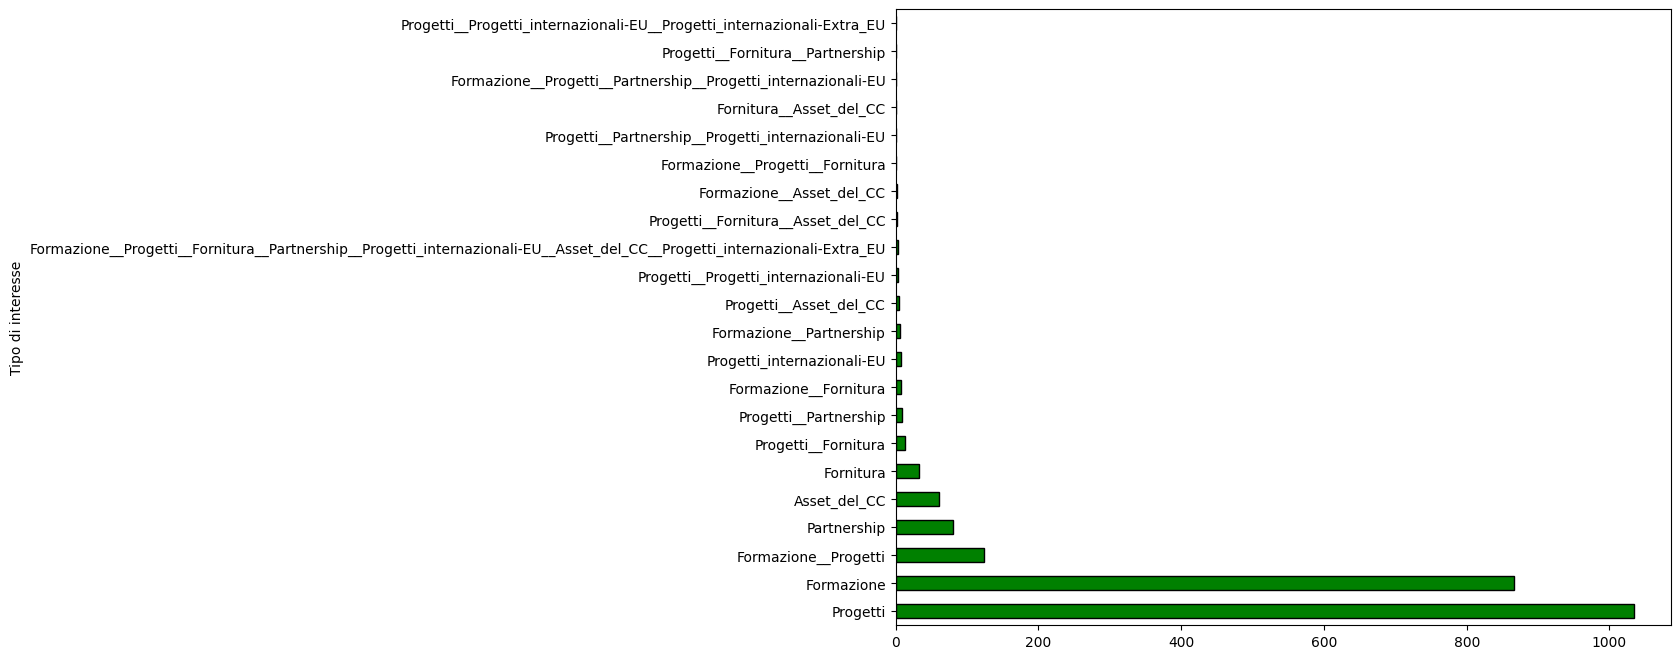

In [33]:
plt.figure(figsize=(10,8))
accounts["Tipo di interesse"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

In [34]:
macro = ["Formazione", "Progetti"]

In [35]:
def accorpa_categoria(cat):
    first = cat.split("__")[0] 
    return first if first in macro else "Partnership_Fornitura_Asset"

In [36]:
accounts['Tipo di interesse'] = accounts['Tipo di interesse'].apply(accorpa_categoria)

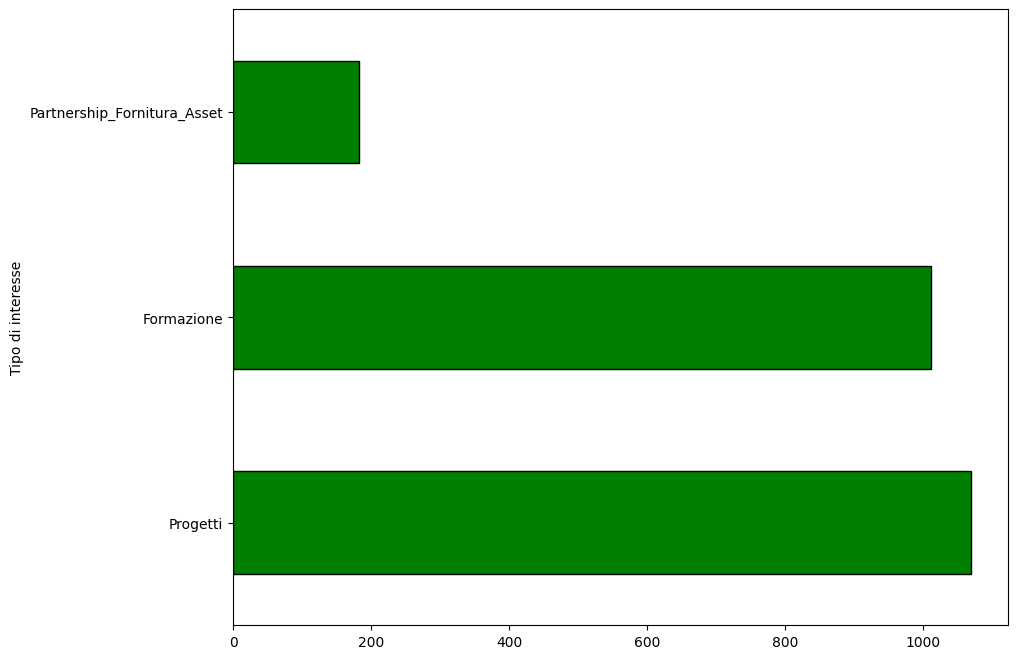

In [37]:
plt.figure(figsize=(10,8))
accounts["Tipo di interesse"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

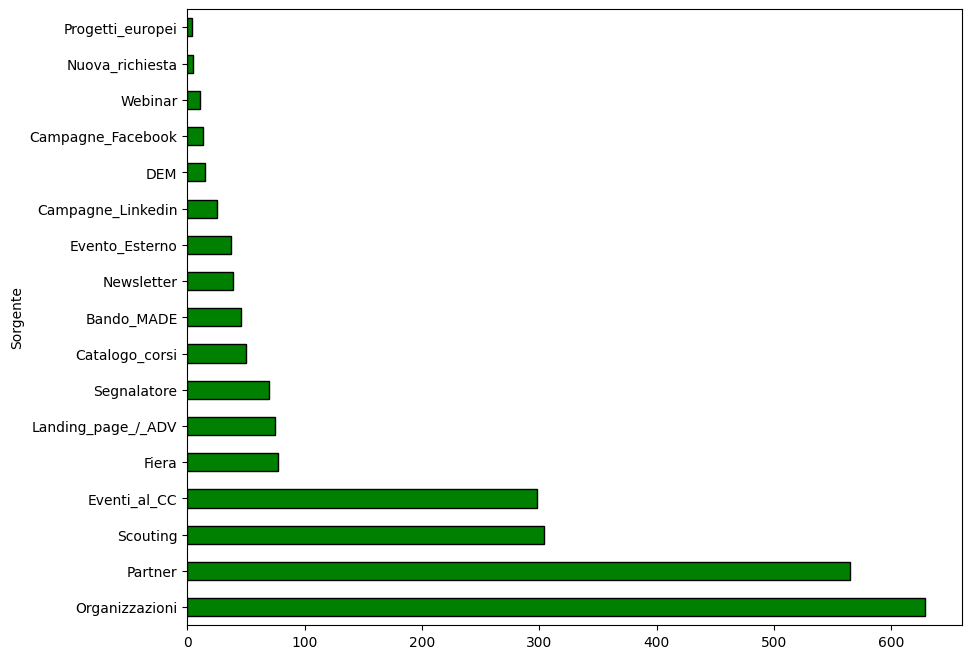

In [38]:
plt.figure(figsize=(10,8))
accounts["Sorgente"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

In [39]:
mappa = {
    "Organizzazioni": "Network",
    "Partner": "Network",
    "Scouting": "Scouting",
    "Segnalatore": "Network",
    "Eventi_al_CC": "Eventi",
    "Evento_Esterno": "Eventi",
    "Fiera": "Eventi",
    "Webinar": "Eventi",
    "Newsletter": "Altro",
    "DEM": "Altro",
    "Landing_page_/_ADV": "Altro",
    "Campagne_Linkedin": "Altro",
    "Campagne_Facebook": "Altro",
    "Bando_MADE": "Altro",
    "Progetti_europei": "Altro",
    "Nuova_richiesta": "Altro",
    "Catalogo_corsi": "Altro"
}

In [40]:
accounts["Sorgente"] = accounts["Sorgente"].map(mappa).fillna("Altro")

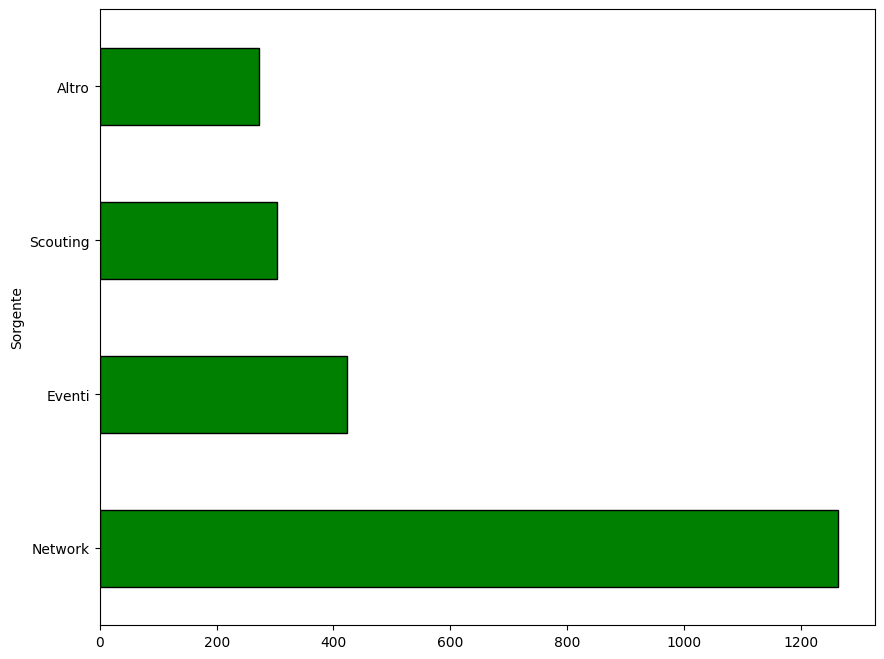

In [41]:
plt.figure(figsize=(10,8))
accounts["Sorgente"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

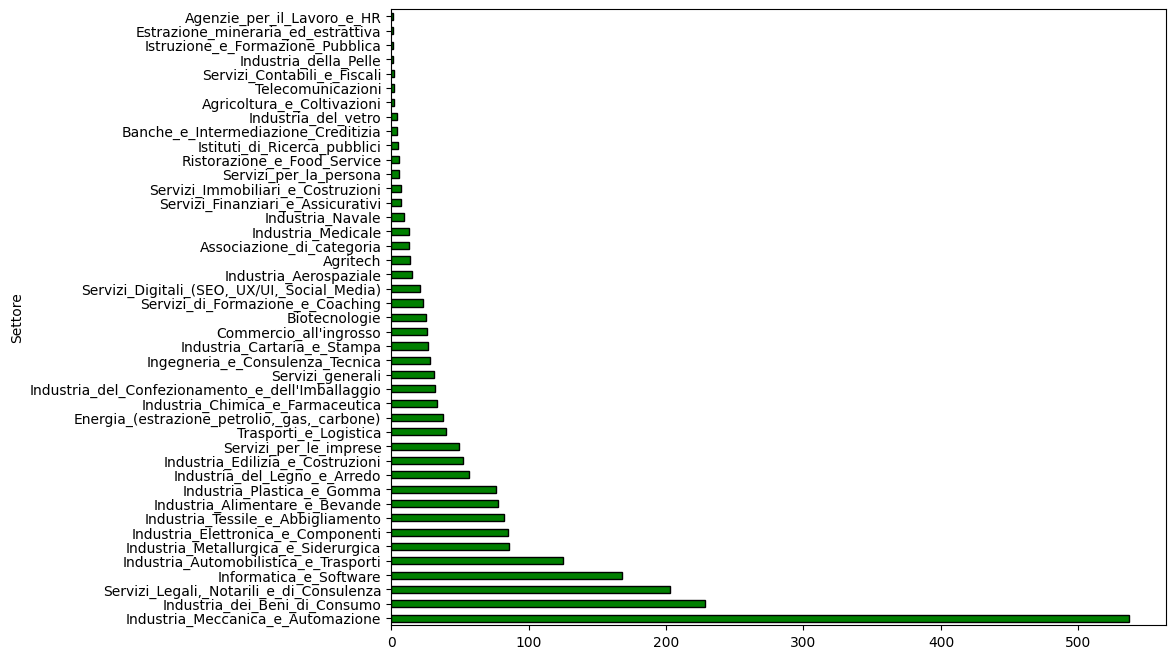

In [42]:
plt.figure(figsize=(10,8))
accounts["Settore"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

In [43]:
mapping = {
    
    # INDUSTRIA
    'Industria_Plastica_e_Gomma': 'Industria',
    'Industria_Alimentare_e_Bevande': 'Industria',
    'Industria_Tessile_e_Abbigliamento': 'Industria',
    'Industria_dei_Beni_di_Consumo': 'Industria',
    'Industria_Chimica_e_Farmaceutica': 'Industria',
    'Industria_Meccanica_e_Automazione': 'Industria',
    "Industria_del_Confezionamento_e_dell'Imballaggio": 'Industria',
    'Industria_Automobilistica_e_Trasporti': 'Industria',
    'Industria_del_Legno_e_Arredo': 'Industria',
    'Industria_Elettronica_e_Componenti': 'Industria',
    'Industria_Edilizia_e_Costruzioni': 'Industria',
    'Industria_Metallurgica_e_Siderurgica': 'Industria',
    'Industria_Aerospaziale': 'Industria',
    'Industria_Cartaria_e_Stampa': 'Industria',
    'Industria_Navale': 'Industria',
    'Industria_Medicale': 'Industria',

    # ALTRO
    
    # energia e trasporti
    'Energia_(estrazione_petrolio,_gas,_carbone)': 'Altro',
    'Trasporti_e_Logistica': 'Altro',

    # servizi
    'Servizi_Digitali_(SEO,_UX/UI,_Social_Media)': 'Altro',
    'Servizi_Legali,_Notarili_e_di_Consulenza': 'Altro',
    'Ingegneria_e_Consulenza_Tecnica': 'Altro',
    'Servizi_per_le_imprese': 'Altro',
    'Servizi_Finanziari_e_Assicurativi': 'Altro',
    'Servizi_Immobiliari_e_Costruzioni': 'Altro',
    'Servizi_di_Formazione_e_Coaching': 'Altro',

    # informatica
    'Informatica_e_Software': 'Altro',
    'Biotecnologie': 'Altro',
    'Agritech': 'Altro',
    'Telecomunicazioni': 'Altro',

    # ristorazione
    'Ristorazione_e_Food_Service': 'Altro',
    "Commercio_all'ingrosso": 'Altro',

    # istituzioni
    'Associazione_di_categoria': 'Altro',
    'Banche_e_Intermediazione_Creditizia': 'Altro'
}

In [44]:
accounts['Settore'] = accounts['Settore'].map(mapping)

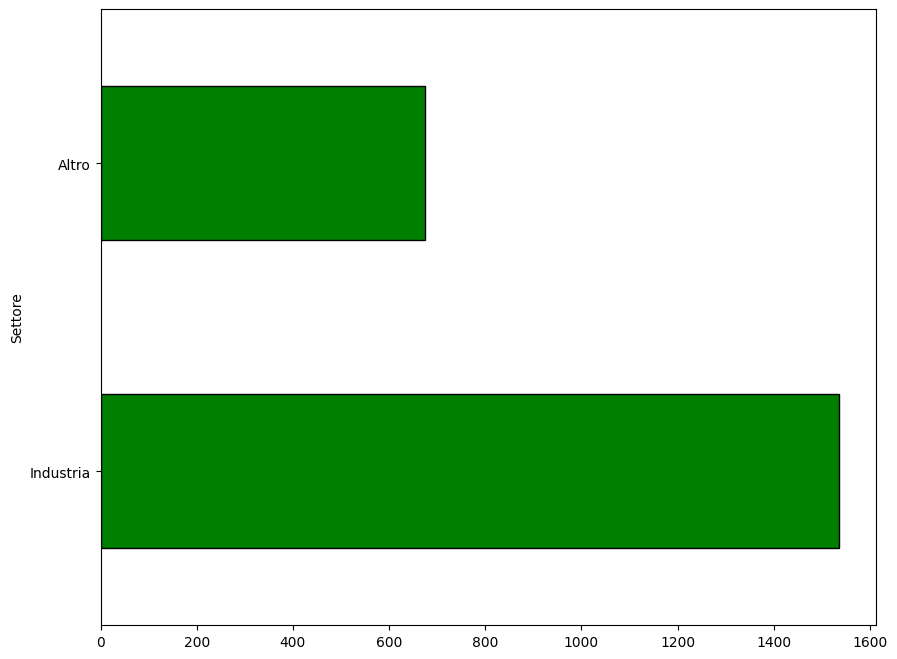

In [45]:
plt.figure(figsize=(10,8))
accounts["Settore"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

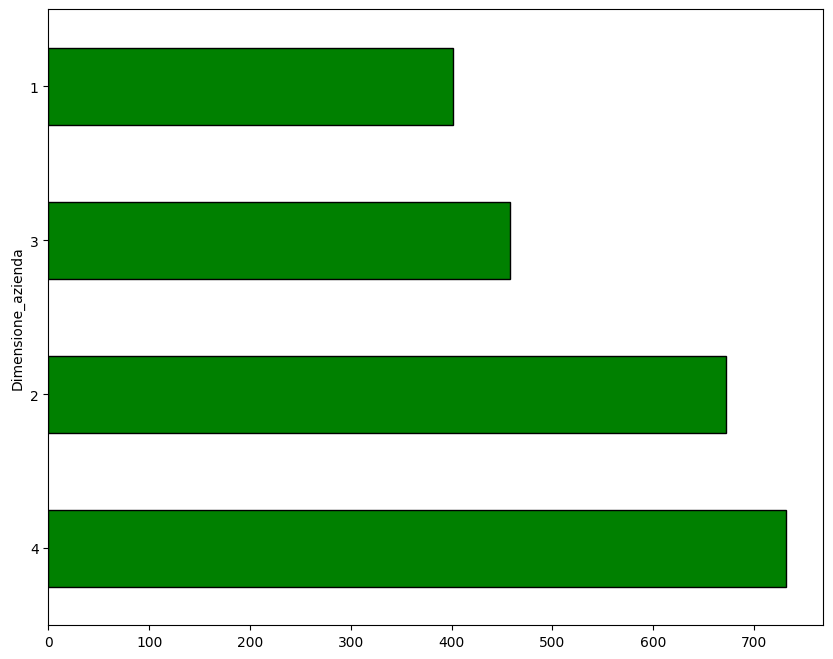

In [46]:
plt.figure(figsize=(10,8))
accounts["Dimensione_azienda"].value_counts().plot(kind='barh', color='green', edgecolor='black')
plt.show()

In [47]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti,Ricavi_per_dipendente,Dimensione_azienda
0,Ascom UMS Srl,Altro,Partnership_Fornitura_Asset,Scouting,Industria,15.955577,4.330733,-0.240607,3
1,Ubiquicom S.r.l.,Ingaggiato,Partnership_Fornitura_Asset,Altro,Altro,15.123844,3.828641,-0.418866,2
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria,17.989898,6.398595,-0.265670,4
3,RAL FILATI SRL,Cliente,Formazione,Network,Industria,16.464125,3.663562,0.419562,4
4,ZERBI S.R.L.,Cliente,Formazione,Network,Altro,15.805284,2.708050,0.608254,2
...,...,...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Network,Industria,16.523561,4.060443,0.227347,3
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Network,Industria,17.216708,5.141664,0.005374,3
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi,Industria,19.673444,5.303305,1.279785,4
2279,40factory,Cliente,Formazione,Altro,Altro,14.077876,2.833213,-0.425473,2


## clustering

In [48]:
df_clustering = accounts.drop(columns={'Nome account', 'Ricavi annuali', 'Numero di dipendenti'},axis=1)

In [49]:
df_clustering

,Status,Tipo di interesse,Sorgente,Settore,Ricavi_per_dipendente,Dimensione_azienda
0,Altro,Partnership_Fornitura_Asset,Scouting,Industria,-0.240607,3
1,Ingaggiato,Partnership_Fornitura_Asset,Altro,Altro,-0.418866,2
2,Ingaggiato,Progetti,Scouting,Industria,-0.265670,4
3,Cliente,Formazione,Network,Industria,0.419562,4
4,Cliente,Formazione,Network,Altro,0.608254,2
...,...,...,...,...,...,...
2276,Ingaggiato,Progetti,Network,Industria,0.227347,3
2277,Ingaggiato,Progetti,Network,Industria,0.005374,3
2278,Ingaggiato,Formazione,Eventi,Industria,1.279785,4
2279,Cliente,Formazione,Altro,Altro,-0.425473,2


In [50]:
distant_matrix = gower.gower_matrix(df_clustering)

In [51]:
k_values = range(2, 10)
within_diss = []

for k in k_values:
    initial_medoids = np.random.choice(range(len(distant_matrix)), k, replace=False).tolist()
    pam = kmedoids(distant_matrix, initial_medoids, data_type='distance_matrix')
    pam.process()
    clusters = pam.get_clusters()
    medoids = pam.get_medoids()
    
    total = 0
    for m, cluster in zip(medoids, clusters):
        total += np.sum([distant_matrix[m][i] for i in cluster])
    
    within_diss.append(total)

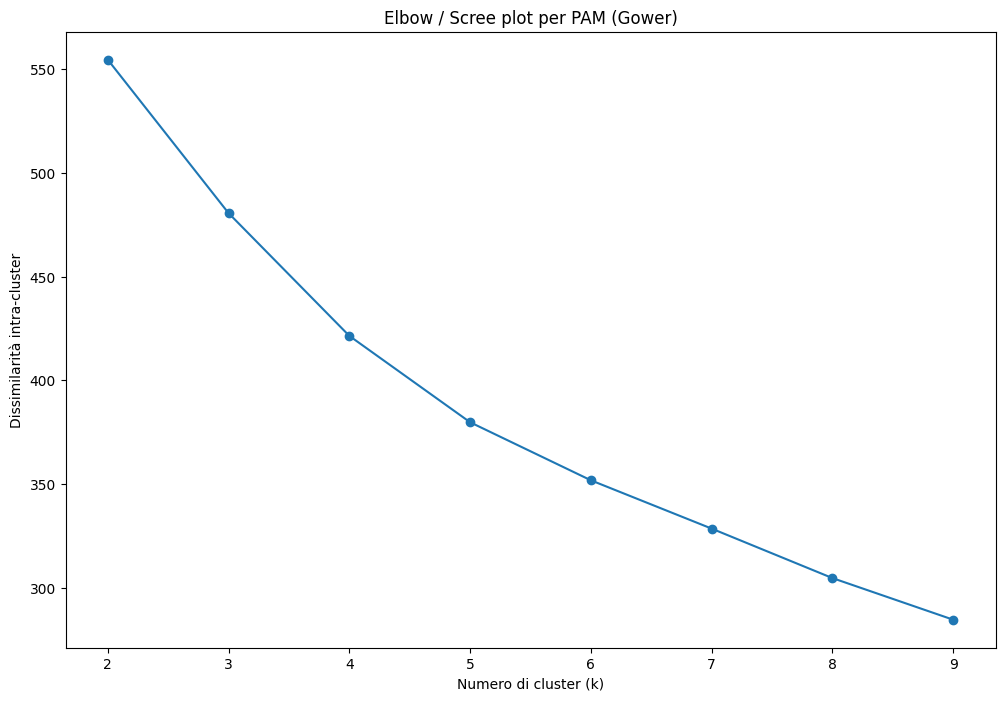

In [52]:
plt.figure(figsize=(12,8))
plt.plot(k_values, within_diss, marker='o')
plt.xlabel("Numero di cluster (k)")
plt.ylabel("Dissimilarità intra-cluster")
plt.title("Elbow / Scree plot per PAM (Gower)")
plt.show()

In [53]:
initial_medoids = np.random.choice(len(df_clustering),4,replace=False)

In [54]:
pam = kmedoids(distant_matrix, initial_medoids, data_type='distance_matrix')

In [55]:
pam.process()

In [56]:
clusters = pam.get_clusters()

In [57]:
medoids = pam.get_medoids()

In [58]:
labels = np.zeros(len(df_clustering))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [59]:
accounts['pam'] = labels

In [60]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti,Ricavi_per_dipendente,Dimensione_azienda,pam
0,Ascom UMS Srl,Altro,Partnership_Fornitura_Asset,Scouting,Industria,15.955577,4.330733,-0.240607,3,2.0
1,Ubiquicom S.r.l.,Ingaggiato,Partnership_Fornitura_Asset,Altro,Altro,15.123844,3.828641,-0.418866,2,3.0
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria,17.989898,6.398595,-0.265670,4,1.0
3,RAL FILATI SRL,Cliente,Formazione,Network,Industria,16.464125,3.663562,0.419562,4,0.0
4,ZERBI S.R.L.,Cliente,Formazione,Network,Altro,15.805284,2.708050,0.608254,2,3.0
...,...,...,...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Network,Industria,16.523561,4.060443,0.227347,3,2.0
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Network,Industria,17.216708,5.141664,0.005374,3,2.0
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi,Industria,19.673444,5.303305,1.279785,4,1.0
2279,40factory,Cliente,Formazione,Altro,Altro,14.077876,2.833213,-0.425473,2,3.0


In [61]:
df_grouped = accounts.groupby('pam').agg({
    'Ricavi_per_dipendente': 'mean',
    'Dimensione_azienda': lambda x: x.mode()[0],
    'Status': lambda x: x.mode()[0],
    'Tipo di interesse': lambda x: x.mode()[0],
    'Sorgente': lambda x: x.mode()[0]
})

In [62]:
df_grouped

,Ricavi_per_dipendente,Dimensione_azienda,Status,Tipo di interesse,Sorgente
pam,,,,,
0.0,0.031217,2,Cliente,Formazione,Network
1.0,0.183747,4,Ingaggiato,Progetti,Eventi
2.0,0.068256,3,Ingaggiato,Progetti,Network
3.0,-0.310333,1,Cliente,Formazione,Network


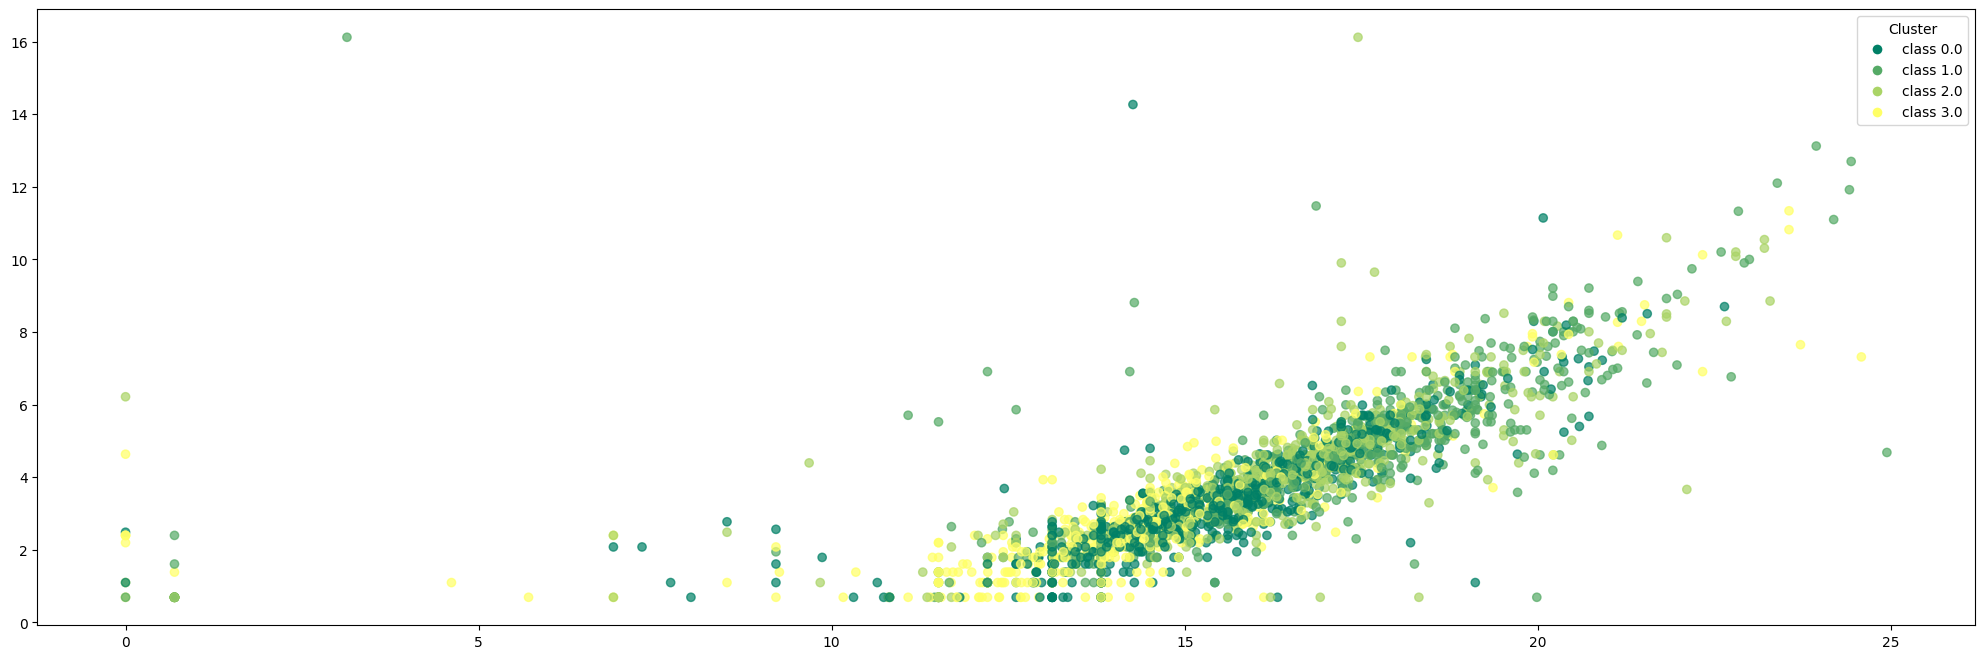

In [63]:
plt.figure(figsize=(25,8))
scatter = plt.scatter(accounts['Ricavi annuali'],accounts['Numero di dipendenti'], 
                      c=accounts['pam'],cmap='summer',alpha=0.7)

unique_labels = np.unique(accounts['pam'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

In [64]:
fig = px.scatter(
    accounts,
    x="Ricavi annuali",
    y="Numero di dipendenti",
    color="pam",
    hover_name="Nome account",  
    hover_data={
        "Ricavi annuali": False, 
        "Numero di dipendenti": False,
        "pam": True
    },
    title="Clustering Accounts",
    width=1300,
    height=800,
)

fig.update_layout(
    xaxis_title="Ricavi annuali (log)",
    yaxis_title="Numero di dipendenti (log)",
    legend_title="Cluster"
)

fig.show()

## umap

In [65]:
df_clustering

,Status,Tipo di interesse,Sorgente,Settore,Ricavi_per_dipendente,Dimensione_azienda
0,Altro,Partnership_Fornitura_Asset,Scouting,Industria,-0.240607,3
1,Ingaggiato,Partnership_Fornitura_Asset,Altro,Altro,-0.418866,2
2,Ingaggiato,Progetti,Scouting,Industria,-0.265670,4
3,Cliente,Formazione,Network,Industria,0.419562,4
4,Cliente,Formazione,Network,Altro,0.608254,2
...,...,...,...,...,...,...
2276,Ingaggiato,Progetti,Network,Industria,0.227347,3
2277,Ingaggiato,Progetti,Network,Industria,0.005374,3
2278,Ingaggiato,Formazione,Eventi,Industria,1.279785,4
2279,Cliente,Formazione,Altro,Altro,-0.425473,2


In [66]:
distant_matrix = gower.gower_matrix(df_clustering)

In [67]:
umap_model = umap.UMAP(n_components=3,n_neighbors=30,min_dist=0.1,metric='precomputed',random_state=42)

In [68]:
accounts_umap = umap_model.fit_transform(distant_matrix)

In [69]:
umap_columns = [f'dim_{i+1}' for i in range(3)]

In [70]:
X_umap = pd.DataFrame(accounts_umap, columns=umap_columns)

In [71]:
X_umap

,dim_1,dim_2,dim_3
0,13.038492,4.265309,7.148005
1,10.279880,5.359953,7.939591
2,5.903164,4.420834,7.133720
3,8.478788,9.354281,1.218266
4,14.596409,7.556908,-3.194896
...,...,...,...
2258,-6.962048,7.461369,4.187180
2259,-7.091681,7.492842,3.119318
2260,9.100375,7.864381,7.320008
2261,9.986348,6.763159,4.441277


## umap + clustering

In [72]:
initial_medoids = np.random.choice(len(X_umap),4,replace=False)

In [73]:
metric = distance_metric(type_metric.EUCLIDEAN)

In [74]:
pam_umap = kmedoids(X_umap.values.tolist(),initial_medoids,metric=metric)

In [75]:
pam_umap.process()

In [76]:
clusters = pam_umap.get_clusters()

In [77]:
medoids = pam_umap.get_medoids()

In [78]:
labels = np.zeros(len(X_umap))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [79]:
df_pam_umap = X_umap.copy()

In [80]:
accounts['pam_umap'] = labels

In [81]:
accounts

,Nome account,Status,Tipo di interesse,Sorgente,Settore,Ricavi annuali,Numero di dipendenti,Ricavi_per_dipendente,Dimensione_azienda,pam,pam_umap
0,Ascom UMS Srl,Altro,Partnership_Fornitura_Asset,Scouting,Industria,15.955577,4.330733,-0.240607,3,2.0,1.0
1,Ubiquicom S.r.l.,Ingaggiato,Partnership_Fornitura_Asset,Altro,Altro,15.123844,3.828641,-0.418866,2,3.0,1.0
2,Marchi & Fildi S.p.A.,Ingaggiato,Progetti,Scouting,Industria,17.989898,6.398595,-0.265670,4,1.0,0.0
3,RAL FILATI SRL,Cliente,Formazione,Network,Industria,16.464125,3.663562,0.419562,4,0.0,2.0
4,ZERBI S.R.L.,Cliente,Formazione,Network,Altro,15.805284,2.708050,0.608254,2,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2276,CAODURO S.P.A.,Ingaggiato,Progetti,Network,Industria,16.523561,4.060443,0.227347,3,2.0,0.0
2277,GRUPPO PONTIGGIA S.R.L.,Ingaggiato,Progetti,Network,Industria,17.216708,5.141664,0.005374,3,2.0,0.0
2278,SEDAMYL S.P.A.,Ingaggiato,Formazione,Eventi,Industria,19.673444,5.303305,1.279785,4,1.0,1.0
2279,40factory,Cliente,Formazione,Altro,Altro,14.077876,2.833213,-0.425473,2,3.0,1.0


In [82]:
df_grouped = accounts.groupby('pam_umap').agg({
    'Ricavi_per_dipendente': 'mean',
    'Dimensione_azienda': lambda x: x.mode()[0],
    'Status': lambda x: x.mode()[0],
    'Tipo di interesse': lambda x: x.mode()[0],
    'Sorgente': lambda x: x.mode()[0],
    'Settore': lambda x: x.mode()[0]
})

In [83]:
df_grouped

,Ricavi_per_dipendente,Dimensione_azienda,Status,Tipo di interesse,Sorgente,Settore
pam_umap,,,,,,
0.0,0.208848,4,Ingaggiato,Progetti,Network,Industria
1.0,-0.080138,4,Cliente,Progetti,Eventi,Industria
2.0,-0.010991,2,Cliente,Formazione,Network,Industria
3.0,0.132238,4,Ingaggiato,Progetti,Eventi,Industria


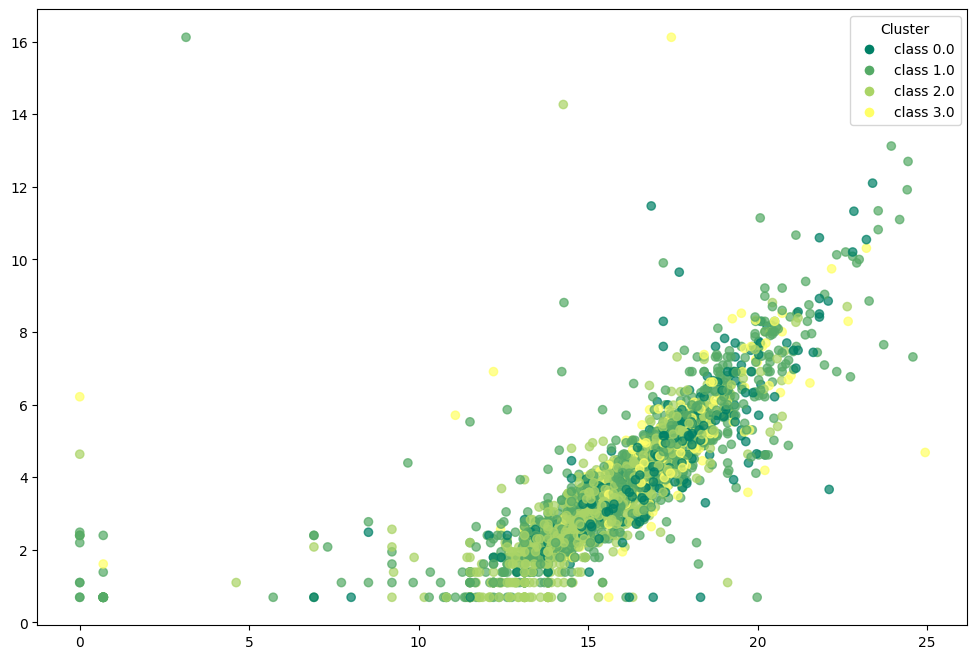

In [84]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(accounts['Ricavi annuali'],accounts['Numero di dipendenti'], 
                      c=accounts['pam_umap'],cmap='summer',alpha=0.7)

unique_labels = np.unique(accounts['pam_umap'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

In [85]:
fig = px.scatter(
    accounts,
    x="Ricavi annuali",
    y="Numero di dipendenti",
    color="pam_umap",
    hover_name="Nome account",  
    hover_data={
        "Ricavi annuali": False, 
        "Numero di dipendenti": False,
        "pam_umap": True
    },
    title="Clustering Accounts",
    width=1300,
    height=800,
)

fig.update_layout(
    xaxis_title="Ricavi annuali (log)",
    yaxis_title="Numero di dipendenti (log)",
    legend_title="Cluster"
)

fig.show()